<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/02-vae-keras-mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Checking dependencies

In [0]:
!nvidia-smi

Mon Oct 14 12:06:41 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Imports

In [0]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import keras

print('keras:', keras.__version__)

Using TensorFlow backend.


keras: 2.2.5


## Utilities

In [0]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon
  
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

## MNIST dataset

In [0]:
(x_train, train_labels), (x_test, _) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

print('image size:', image_size)
print('x_train.shape:', x_train.shape)
print('x_test.shape:', x_test.shape)


11493376/11490434 [==============================] - 1s 0us/step
image size: 28
x_train.shape: (60000, 784)
x_test.shape: (10000, 784)


## Network parameters

In [0]:
input_shape = (original_dim, )
intermediate_dim =  512
batch_size = 128
latent_dim = 2
epochs = 50
print('input shape:', input_shape)

input shape: (784,)


## VAE model = encoder + decoder

In [0]:
# build enconder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu', name='intermediate_dense')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

Use reparameterization trick to push the sampling out as a input note that "output_shape" isn't nessesary with the TF

In [0]:
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
intermediate_dense (Dense)      (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        intermediate_dense[0][0]         
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        intermediate_dense[0][0]         
____________________________________________________________________________________________

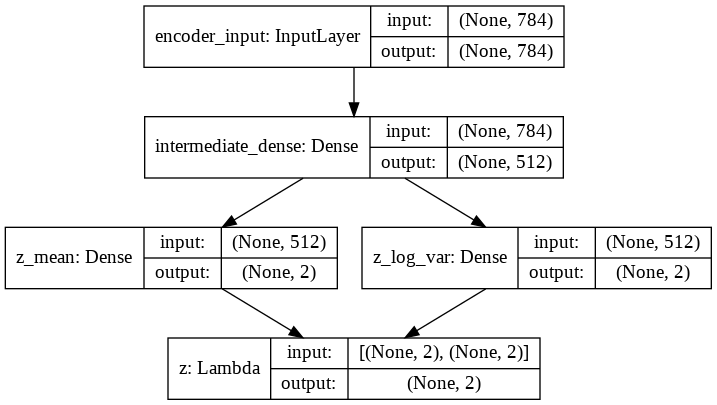

In [0]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_enconder.png', show_shapes=True)

Build and Instantiate the decoder model


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
intermediate_latent_inputs ( (None, 512)               1536      
_________________________________________________________________
dense_1 (Dense)              (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


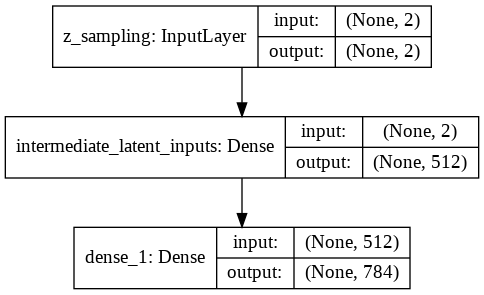

In [0]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu', 
          name='intermediate_latent_inputs')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)


## Instantiate VAE model

In [0]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')


In [0]:
models = (encoder, decoder)
data = (x_test, train_labels)

In [0]:
# VAE loss = mse_loss or xent_loss + kl_loss
reconstruction_loss = mse(inputs, outputs)
# reconstruction_loss = binary_crossentropy(inputs, outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5


Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


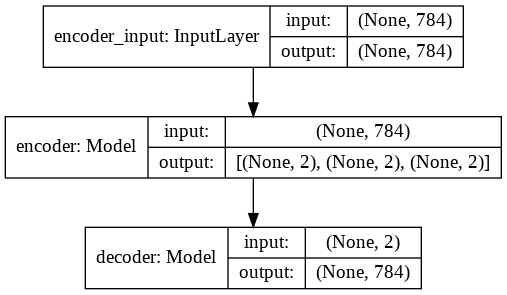

In [0]:
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
plot_model(vae,
               to_file='vae_mlp.png',
               show_shapes=True)

In [0]:
vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))




Train on 60000 samples, validate on 10000 samples
Epoch 1/50





60000/60000 [==============================] - 8s 137us/step - loss: 52.0632 - val_loss: 44.2174
Epoch 2/50
60000/60000 [==============================] - 4s 63us/step - loss: 43.3078 - val_loss: 42.7632
Epoch 3/50
60000/60000 [==============================] - 4s 63us/step - loss: 42.3041 - val_loss: 41.9920
Epoch 4/50
60000/60000 [==============================] - 4s 63us/step - loss: 41.6414 - val_loss: 41.3958
Epoch 5/50
60000/60000 [==============================] - 4s 63us/step - loss: 41.1369 - val_loss: 40.9964
Epoch 6/50
60000/60000 [==============================] - 4s 62us/step - loss: 40.7381 - val_loss: 40.5414
Epoch 7/50
60000/60000 [==============================] - 4s 64us/step - loss: 40.3758 - val_loss: 40.3286
Epoch 8/50
60000/60000 [==============================] - 4s 62us/step - loss: 40.0940 - val_loss: 40.0302
Epoch 9/50
60000/60000 [==============================] - 4s 63us/step - loss: 39.823

ValueError: ignored

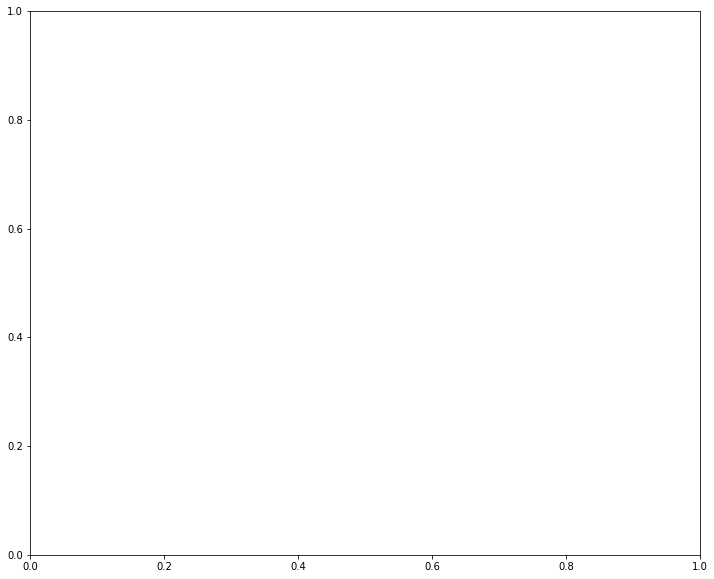

In [0]:
plot_results(models,
                 data,
                 batch_size=batch_size,
                 model_name="vae_mlp")